### Setup

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import matplotlib as mpl

import json
from pandas.io.json import json_normalize
from scipy.stats import zscore
import scipy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from adjustText import adjust_text

In [4]:
#clean up default font to be more 'figure ready'
sns.set(font_scale=2)
sns.set_style('ticks')
new_rc_params = {'text.usetex': False, "svg.fonttype": 'none',
                 "axes.spines.right": False,
                 "axes.spines.top": False,
                 "axes.linewidth": 1.2,
                 "xtick.major.size": 6,
                 "xtick.major.width": 1.2,
                 "ytick.major.size": 6,
                 "ytick.major.width": 1.2,
                 "legend.frameon": False,
                 "legend.handletextpad": 0.1,
                 "font.family": 'arial', "font.size": 12,                 
}
mpl.rcParams.update(new_rc_params)

### load data

In [7]:
#laod diff data from figure 2 notebook
%store -r  cleaned_all_cfos_diff

### preprocessing for quadrants

In [14]:
#calculate CIs first
#psilocybin
ax = sns.pointplot(y='Region_Name', x='psi-sal', data = cleaned_all_cfos_diff,
                   ci=95, join=False, units=16, errwidth = 0.5,
                   color='red',dodge=True)

psi_lower = [line.get_xdata().min() for line in ax.lines]
psi_upper = [line.get_xdata().max() for line in ax.lines]
plt.close() #no need to see output....

#ketamine
ax = sns.pointplot(y='Region_Name', x='ket-sal', data = cleaned_all_cfos_diff ,
                   ci=95, join=False, units=16, errwidth = 0.5,
                   color='blue',dodge=True)

ket_lower = [line.get_xdata().min() for line in ax.lines]
ket_upper = [line.get_xdata().max() for line in ax.lines]
plt.close() #no need to see output....

In [15]:
#assign changes based on psi or ket difference from saline first

#select interesting ROIs to highlight
all_selected_ROI = [39, 48, 972, 104, 961, 44, #most of cortex
                    385, 425, 402, 533, 394, #visual areas
                    879, 886, 894, #retrosplenial
                    147, 583, 536, 295, 319, # amygdala
                    255, 64, 59, 362, 262, #thalamus
                    672, 795, 1048, #subcortical significant
                    872, 238, 206, 230, 222, #raphe
                    351, 382, 463, 502, #ketamine subcortical
                    56, 749] #subcortical non significant

#get clean copy data
quadrant_compare = cleaned_all_cfos_diff  #cleaned_s2p_diff #cleaned_lightsheet_diff 
quadrant_compare = quadrant_compare.groupby(['Region_Name','abbreviation'],sort=False)['psi-sal','psi-ket','ket-sal'].mean().reset_index()

#select regions
all_select = all_selected_ROI
quadrant_compare_select = cleaned_all_cfos_diff[cleaned_all_cfos_diff['Region_ID'].isin(all_select)]
quadrant_compare_select = quadrant_compare_select.groupby(['Region_Name','abbreviation'])['psi-sal','psi-ket','ket-sal'].mean().reset_index()

quadrant_compare['ket-sal_upper_ci'] = ket_upper
quadrant_compare['ket-sal_lower_ci'] = ket_lower
quadrant_compare['psi-sal_upper_ci'] = psi_upper
quadrant_compare['psi-sal_lower_ci'] = psi_lower
quadrant_compare['significant'] = None

#calculate
for index, row in quadrant_compare.iterrows():
    #both psi/ket all positive, significant, purple
    if (row['ket-sal_upper_ci'] > 0) and (row['ket-sal_lower_ci'] > 0) and (row['psi-sal_upper_ci'] > 0) and (row['psi-sal_lower_ci'] > 0):
        quadrant_compare.at[index, 'significant'] = 'purple'
    #both psi/ket all negative, significant, purple
    elif (row['ket-sal_upper_ci'] < 0) and (row['ket-sal_lower_ci'] < 0) and (row['psi-sal_upper_ci'] < 0) and (row['psi-sal_lower_ci'] < 0):
        quadrant_compare.at[index, 'significant'] = 'purple'
    #only ketamine significant, blue
    elif ((row['ket-sal_upper_ci'] > 0) and (row['ket-sal_lower_ci'] > 0)) or ((row['ket-sal_upper_ci'] < 0) and (row['ket-sal_lower_ci'] < 0)):
       quadrant_compare.at[index, 'significant'] = 'blue'
    #only psilocybin significant, red
    elif ((row['psi-sal_upper_ci'] > 0) and (row['psi-sal_lower_ci'] > 0)) or ((row['psi-sal_upper_ci'] < 0) and (row['psi-sal_lower_ci'] < 0)):
        quadrant_compare.at[index, 'significant'] = 'red'
    else:
        quadrant_compare.at[index, 'significant'] = 'grey'

### plot

#### zoomed out

Text(0, 0.5, 'Ketamine')

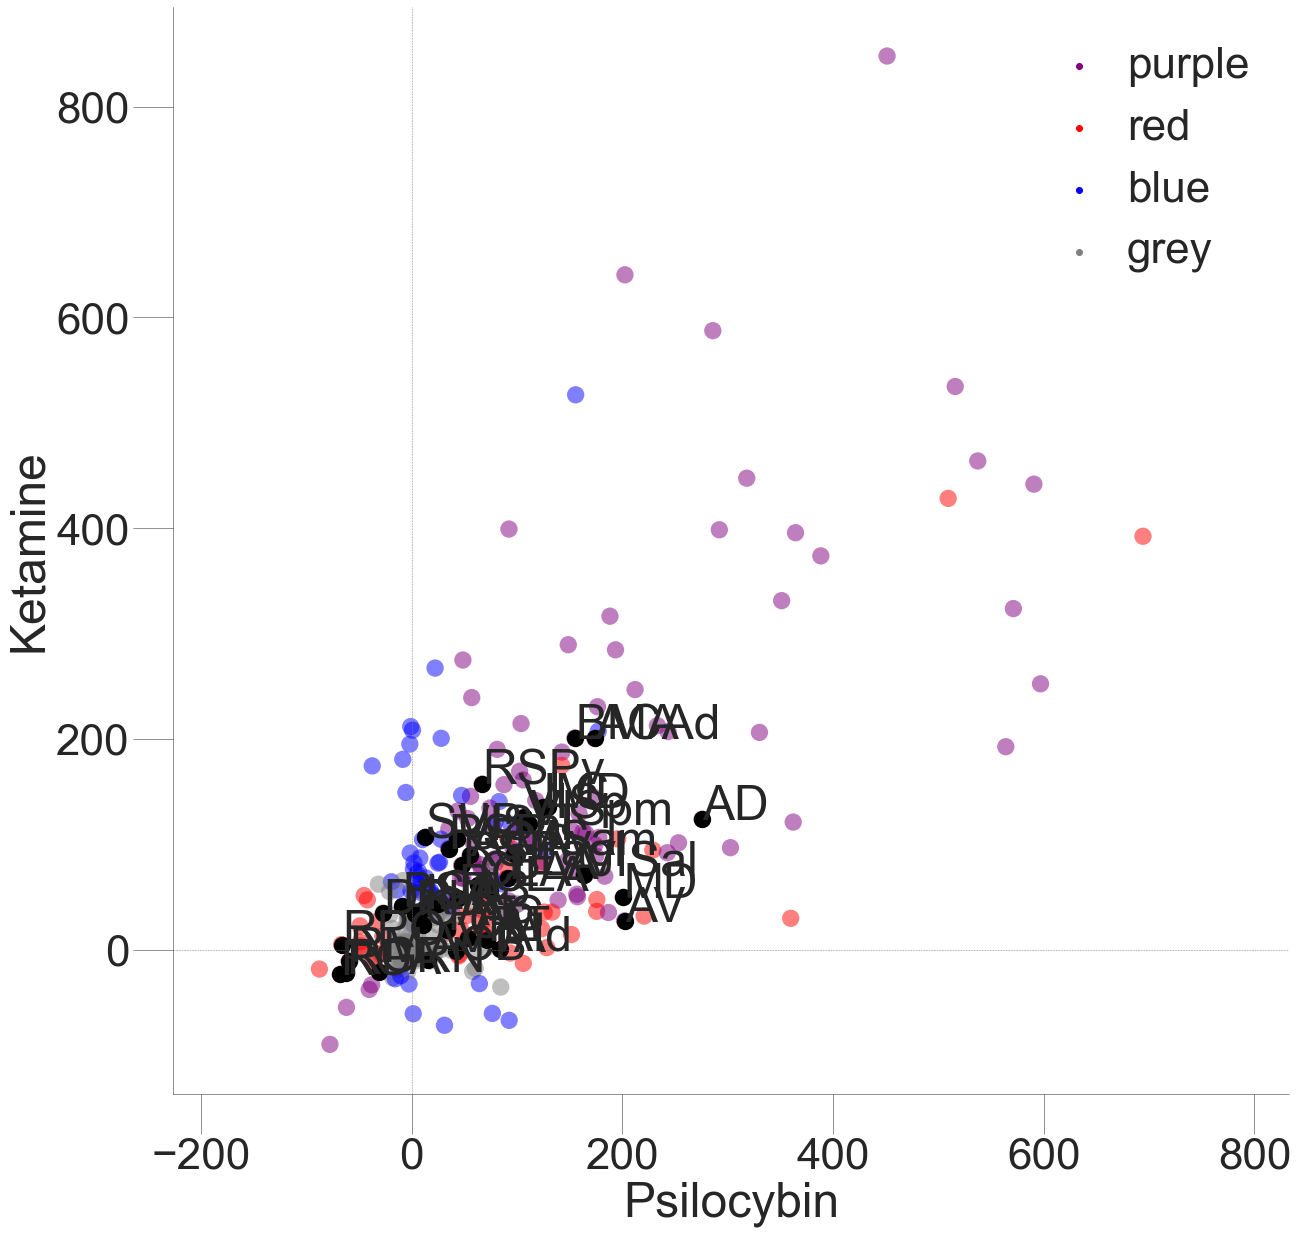

In [21]:
#plot
sns.set(font_scale = 4)
sns.set_style("ticks")
plt.figure(figsize=(20,20))

#get outliers
quadrant_compare_outliers = quadrant_compare.loc[(quadrant_compare['psi-sal']>=400) | (quadrant_compare['ket-sal'] >= 400)]

#actual plot
#add most of data
ax = sns.scatterplot(x="psi-sal", y="ket-sal", data=quadrant_compare,s=300,
                     hue='significant', palette=dict(purple="purple", red="red",blue="blue", grey = "grey"), alpha=0.5, linewidth=0)

#add select data for labels
ax = sns.scatterplot(x="psi-sal", y="ket-sal", data=quadrant_compare_select, #use either quadrant_compare_select or quadrant_compare_outliers
                   s=300, color='black', linewidth=0)

#add labels
#function
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.2, point['y']-0.2, str(point['val']))
#do labeling:
label_point(quadrant_compare_select['psi-sal'],quadrant_compare_select['ket-sal'],quadrant_compare_select['abbreviation'],plt.gca())
#label_point(quadrant_compare_outliers['psi-sal'],quadrant_compare_outliers['ket-sal'],quadrant_compare_outliers['abbreviation'],plt.gca())       


##
sns.despine()
plt.ylabel('Ketamine scaled cell density change (%)')
plt.xlabel('Psilocybin scaled cell density change (%)')
plt.axvline(x=0, linewidth=0.5, color='grey', linestyle='--')
plt.axhline(y=0, linewidth=0.5, color='grey', linestyle='--')

# plt.yscale('symlog')
# plt.xscale('symlog')
plt.axis('equal')

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Psilocybin')
plt.ylabel('Ketamine')

#### zoomed in

(-100.0, 300.0)

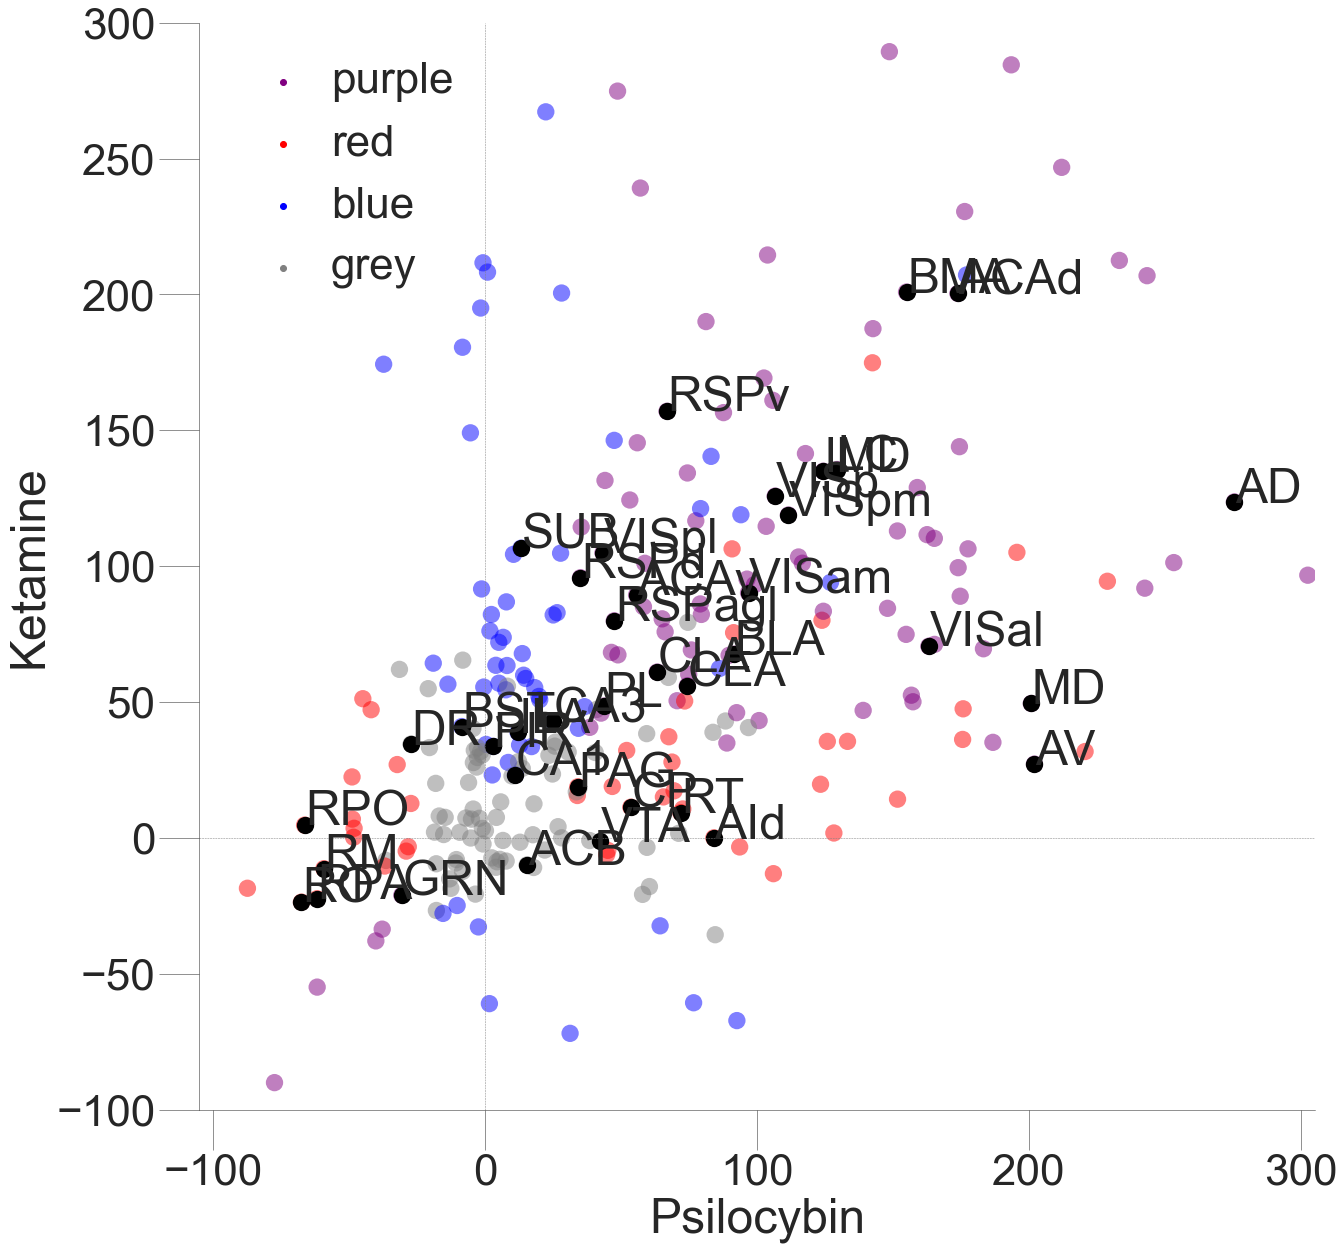

In [22]:
sns.set(font_scale = 4)
sns.set_style("ticks")
plt.figure(figsize=(20,20))

#get outliers
quadrant_compare_outliers = quadrant_compare.loc[(quadrant_compare['psi-sal']>=400) | (quadrant_compare['ket-sal'] >= 400)]

#actual plot
#add most of data
ax = sns.scatterplot(x="psi-sal", y="ket-sal", data=quadrant_compare,s=300,
                     hue='significant', palette=dict(purple="purple", red="red",blue="blue", grey = "grey"), alpha=0.5, linewidth=0)

#add select data for labels
ax = sns.scatterplot(x="psi-sal", y="ket-sal", data=quadrant_compare_select, #use either quadrant_compare_select or quadrant_compare_outliers
                   s=300, color='black', linewidth=0)

#add labels
#function
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+0.2, point['y']-0.2, str(point['val']))
#do labeling:
label_point(quadrant_compare_select['psi-sal'],quadrant_compare_select['ket-sal'],quadrant_compare_select['abbreviation'],plt.gca())
#label_point(quadrant_compare_outliers['psi-sal'],quadrant_compare_outliers['ket-sal'],quadrant_compare_outliers['abbreviation'],plt.gca())       


##
sns.despine()
plt.ylabel('Ketamine scaled cell density change (%)')
plt.xlabel('Psilocybin scaled cell density change (%)')
plt.axvline(x=0, linewidth=0.5, color='grey', linestyle='--')
plt.axhline(y=0, linewidth=0.5, color='grey', linestyle='--')

# plt.yscale('symlog')
# plt.xscale('symlog')
plt.axis('equal')

ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)
ax.xaxis.set_tick_params(length=40, width=0.5)
ax.yaxis.set_tick_params(length=40, width=0.5)
plt.xlabel('Psilocybin')
plt.ylabel('Ketamine')
plt.xlim(-100,300)
plt.ylim(-100,300)